# Watershed Algorithms

In [2]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
# create image displayer
def display(image, cmap='gray'):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap=cmap)

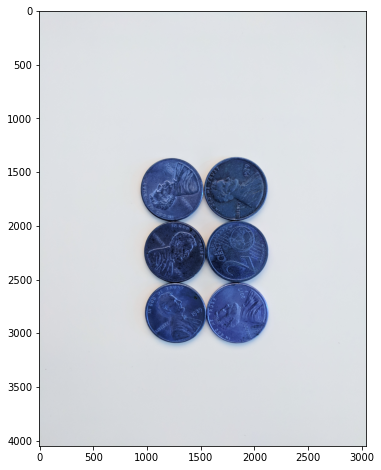

In [4]:
# Get image
coins = cv2.imread('../DATA/pennies.jpg')

display(coins)

Not many algorithms can see the image as six separate coins

In [5]:
# Median blur - To suppresss unimportant features
# Grayscale - To enable other functions
# Binary threshold - separate background and foreground
# FIND CONTOURS

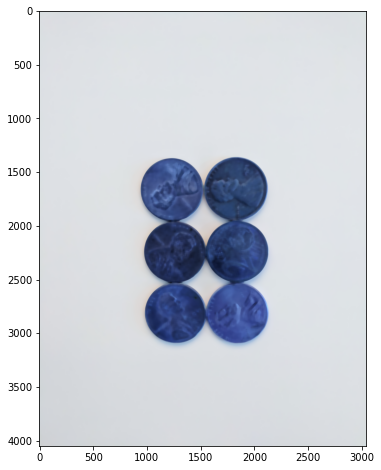

In [6]:
# Create blur
coin_blur = cv2.medianBlur(coins, 25) 

display(coin_blur)

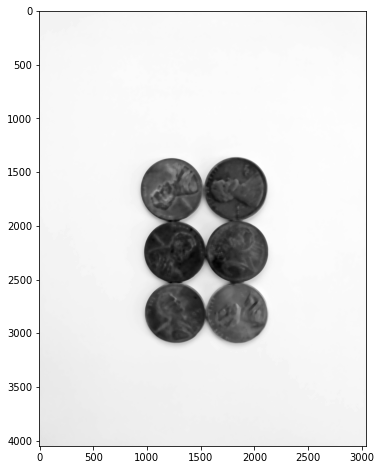

In [7]:
# Make grayscale
gray_coin_blur = cv2.cvtColor(coin_blur, cv2.COLOR_BGR2GRAY)
display(gray_coin_blur)

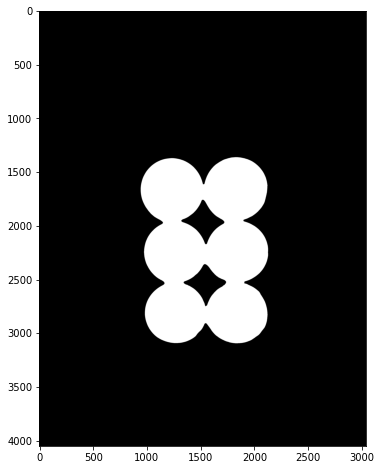

In [8]:
ret, coin_thresh = cv2.threshold(gray_coin_blur, 160, 255, cv2.THRESH_BINARY_INV)

display(coin_thresh)

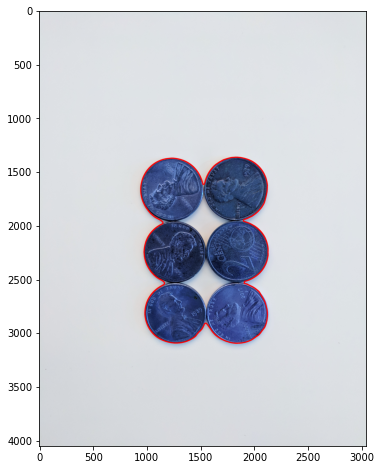

In [9]:
contours, hierarchy = cv2.findContours(coin_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(coins, contours, i, (255,0,0), 10)

display(coins)

In [10]:
# Implement the watershed

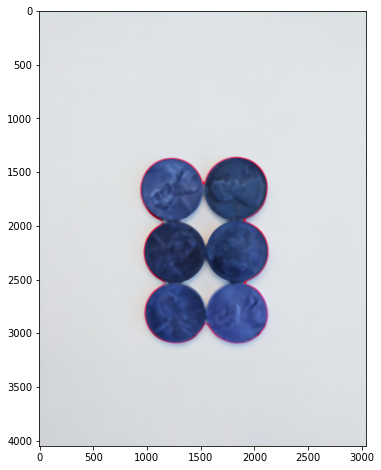

In [11]:
blurred_coins = cv2.medianBlur(coins, 35)
display(blurred_coins)

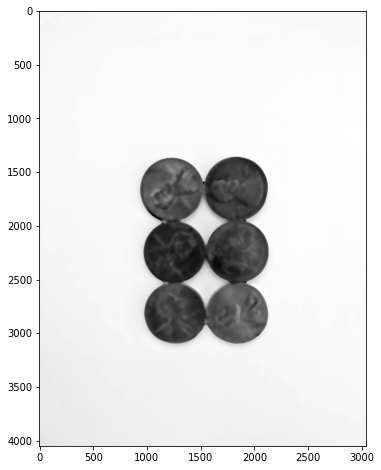

In [12]:
# Convert to gray scale
grayed = cv2.cvtColor(blurred_coins, cv2.COLOR_BGR2GRAY)

display(grayed)

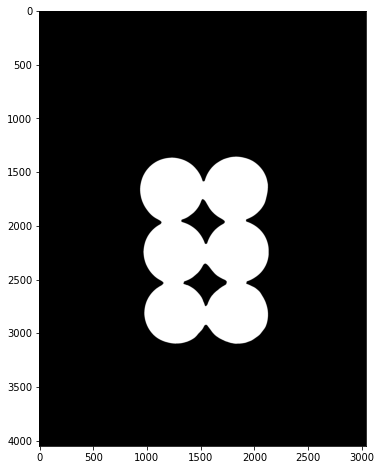

In [13]:
# Apply threshold
ret, coin_thresh = cv2.threshold(grayed, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

display(coin_thresh)

In [14]:
# Remove noise
kernel = np.ones((3,3), np.uint8)

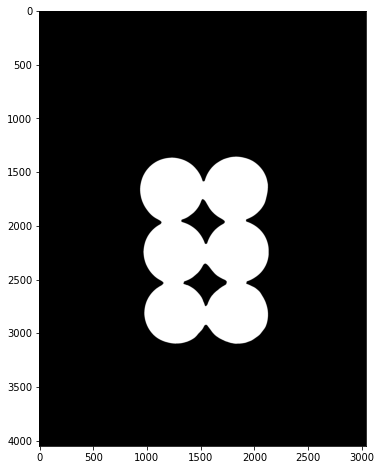

In [15]:
opening = cv2.morphologyEx(coin_thresh, cv2.MORPH_OPEN, kernel, iterations=2)

display(opening)

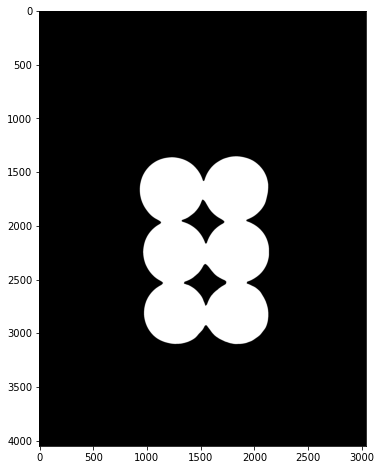

In [16]:
sure_bg = cv2.dilate(opening, kernel, iterations=3)

display(sure_bg)

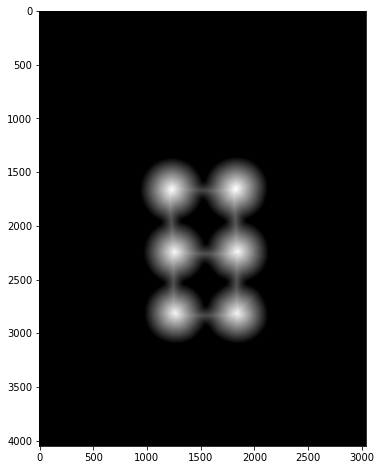

In [17]:
# Perform distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

display(dist_transform)

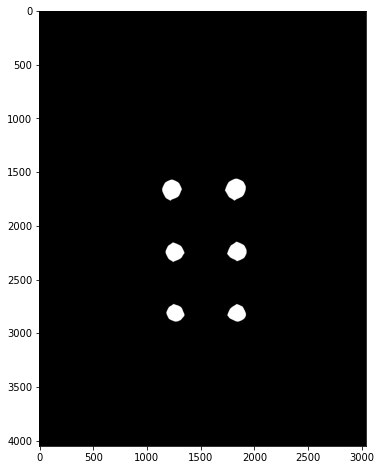

In [18]:
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

display(sure_fg)

In [19]:
sure_fg = np.uint8(sure_fg)

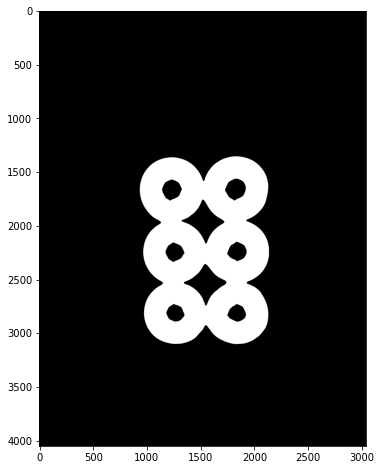

In [20]:
unknown = cv2.subtract(sure_bg, sure_fg)

display(unknown)

In [21]:
# Create label markers for algo
ret, markers = cv2.connectedComponents(sure_fg)

markers +=1


In [22]:
markers[unknown == 255] = 0

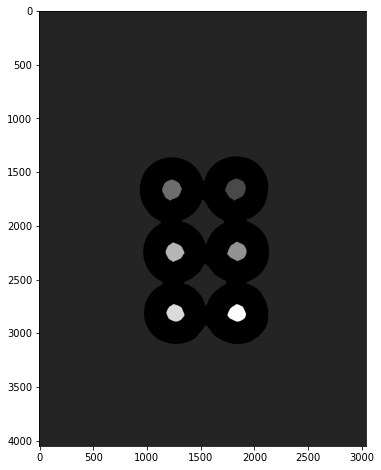

In [23]:
display(markers)

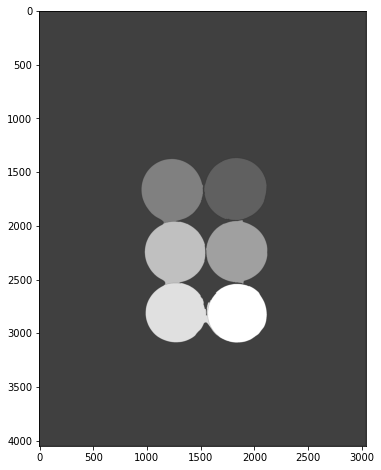

In [24]:
markers = cv2.watershed(coins, markers)
display(markers)

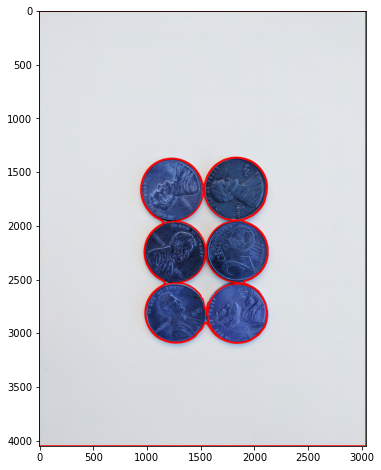

In [25]:
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(coins, contours, i, (255,0,0), 10)

display(coins)

Another way to approach it

In [26]:
road = cv2.imread('../DATA/road_image.jpg')

copy = road.copy()



In [27]:
marker_image = np.zeros(copy.shape[:2], np.int32)
segments = np.zeros_like(copy, np.uint8)

In [28]:
from matplotlib import cm

In [29]:
tuple(np.array(cm.tab10(0)[:3])*255)

(31.0, 119.0, 180.0)

In [30]:
def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3])*255)



In [31]:
colors = []

for i in range(10):
    color = create_rgb(i)
    colors.append(color)

colors

[(31.0, 119.0, 180.0),
 (255.0, 127.0, 14.0),
 (44.0, 160.0, 44.0),
 (214.0, 39.0, 40.0),
 (148.0, 103.0, 189.0),
 (140.0, 86.0, 75.0),
 (227.0, 119.0, 194.0),
 (127.0, 127.0, 127.0),
 (188.0, 189.0, 34.0),
 (23.0, 190.0, 207.0)]

In [32]:
# Global variables
n_markers = len(colors)
current_marker = 1
marker_updated = False

In [33]:
# Callback function

def mouse_callback(event, x,y,flags, param):
    global marker_updated

    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(marker_image, (x,y), 10, (current_marker), -1)

        cv2.circle(copy, (x,y), 10, colors[current_marker], -1)

        marker_updated = True

In [34]:
cv2.namedWindow('Road image')
cv2.setMouseCallback('Road image', mouse_callback)

while True:
    cv2.imshow('Watershed segments', segments)
    cv2.imshow('Road image', copy)

    # Close all windows
    k = cv2.waitKey(1)
    if k == 27:
        break

    # Clear all colors
    elif k == ord('c'):
        road_copy = road.copy()
        marker_image = np.zeros(road.shape[:2], np.int32)
        segments = np.zeros_like(road, np.uint8)
    
    # Update color choice
    elif k >0 and chr(k).isdigit():
        current_marker = int(chr(k))

    if marker_updated:
        marker_image_copy = marker_image.copy()
        cv2.watershed(road, marker_image_copy)
        segments = np.zeros_like(road, np.uint8)

        for color_ind in range(n_markers):
            segments[marker_image_copy == color_ind] = colors[color_ind]

cv2.destroyAllWindows() 